In [2]:
#Import libraries

#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('ggplot')

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# !pip3 install emoji
import emoji
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punkt')
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import treebank_chunk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

#ml
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


In [3]:
df = pd.read_csv('airlines_reviews.csv')
display(df.head(5), df.shape)


ParserError: Error tokenizing data. C error: Expected 17 fields in line 272, saw 20


In [4]:
df.describe()

NameError: name 'df' is not defined

## EDA

In [5]:
# No of reviews per airline
df[['Reviews','Airline']].groupby(['Airline']).count().sort_values(by = 'Airline', ascending= False).reset_index()

NameError: name 'df' is not defined

In [6]:
# Avg rating by airline
df_temp = df[['Overall Rating','Airline']].groupby(['Airline']).mean().sort_values(by = 'Overall Rating', ascending= False).reset_index()
display(df_temp)
sns.barplot(data= df_temp, x='Airline', y='Overall Rating')

plt.ylim(0, 10) 
plt.xticks(rotation=90) 
plt.xlabel('Airline')
plt.ylabel('Average Rating')
plt.title('Average Rating by Airline')
plt.show()

NameError: name 'df' is not defined

In [7]:
#count of ratings
ax = df['Overall Rating'].value_counts().sort_index().plot(kind= 'bar', title= 'Count of Ratings', color = 'darkred')
ax.set_xlabel('Ratings')
ax.set_ylabel('Count of Reviews')
plt.show()

NameError: name 'df' is not defined

In [8]:
#Avg rating per year
df['Review Date'] = pd.to_datetime(df['Review Date'])
df['Year'] = df['Review Date'].dt.year

avg_overall_rating_per_year = df.groupby(['Year'])['Overall Rating'].mean()/2
avg_seat_comfort_rating_per_year = df.groupby(['Year'])['Seat Comfort'].mean()
avg_staff_service_rating_per_year = df.groupby(['Year'])['Staff Service'].mean()
avg_Food_n_Beverages_ratings_per_year = df.groupby(['Year'])['Food & Beverages'].mean()
avg_Inflight_Entertainment_ratings_per_year = df.groupby(['Year'])['Inflight Entertainment'].mean()
avg_Value_For_Money_ratings_per_year = df.groupby(['Year'])['Value For Money'].mean()


fig, ax = plt.subplots(figsize=(15,8))
avg_overall_rating_per_year.plot(kind = 'line',ax = ax, color = 'darkred', linewidth = 5.3)
avg_seat_comfort_rating_per_year.plot(kind = 'line',ax = ax, color = 'darkblue')
avg_staff_service_rating_per_year.plot(kind = 'line',ax = ax)
avg_Food_n_Beverages_ratings_per_year.plot(kind = 'line',ax = ax)
avg_Inflight_Entertainment_ratings_per_year.plot(kind = 'line',ax = ax)
avg_Value_For_Money_ratings_per_year.plot(kind = 'line',ax = ax)

ax.set_title('Avg rating per year')
ax.set_xlabel('Year')
ax.set_ylabel('Rating')
ax.set_ylim(0,5)
ax.grid(True, which = 'both')
ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()

NameError: name 'df' is not defined

In [9]:
#Relationship Between Review Length and Rating
df['review_length'] = df['Reviews'].str.len()

avg_review_length = df.groupby('Overall Rating')['review_length'].mean()
ratings = df['Overall Rating'].unique()

fig, ax = plt.subplots(figsize = (6,4))
ax.bar(ratings, avg_review_length)
ax.set_xlabel('Rating')
ax.set_ylabel('Average Review Length')
ax.set_title('Relationship Between Review Length and Rating')
plt.show()

NameError: name 'df' is not defined

## 3. Preprocessing

In [10]:
X = df['Reviews']
y = df['Overall Rating']

NameError: name 'df' is not defined

### 3.1 Word level Preprocessing

In [11]:

def word_level_preprocessing(text):
    # Convert text to lowercase
    text = text.astype(str).str.lower()
    # Remove emojis
    text = text.apply(lambda x: emoji.demojize(x))
    text = text.str.replace(r':[a-z_]+:', ' ', regex=True)
    # Remove special characters and numbers
    text = text.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    # Tokenization (split the text into words)
    words = text.str.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = words.apply(lambda x: [word for word in x if word not in stop_words])
    # Stemming
    stemmer = PorterStemmer()
    words = words.apply(lambda x: [stemmer.stem(word) for word in x])
    # Join the words back into a single string
    preprocessed_text = words.str.join(' ')
    return preprocessed_text

### 3.2 Sentence level Preprocessing

In [12]:

def sentence_level_preprocessing(text):
     # Convert text to lowercase
    text = text.astype(str).str.lower()
    # Remove emojis
    text = text.apply(lambda x: emoji.demojize(x))
    text = text.str.replace(r':[a-z_]+:', ' ', regex=True)
    # Remove special characters and numbers
    text = text.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    # Tokenization (split the text into sentences)
    sentences = text.apply(lambda x: sent_tokenize(x))
    # Flatten list of sentences
    sentences = sentences.explode()
    
    # POS Tagging
    tagged_sentences = sentences.apply(word_tokenize).apply(pos_tag)
    
    # Parse for sentiment analysis
    
    # Tokenization (split the sentences into words)
    words = tagged_sentences.apply(lambda x: [word for word, tag in x if word not in stopwords.words('english')])
    
    # Stemming
    stemmer = PorterStemmer()
    words = words.apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Join the words back into a single string
    preprocessed_text = words.str.join(' ')
    return preprocessed_text

## NLTK Basics

In [13]:
example = df['Reviews'][50]
print(example)

NameError: name 'df' is not defined

In [20]:
tokens = nltk.word_tokenize(example)
tokens[:20]

['Although',
 'the',
 'aircraft',
 'is',
 'good',
 'with',
 'flat',
 'beds',
 'and',
 'the',
 'crew',
 'is',
 'good',
 ',',
 'the',
 'onboard',
 'selection',
 'of',
 'entertainment',
 'does']

In [21]:
tagged = nltk.pos_tag(tokens[:20])
tagged

[('Although', 'IN'),
 ('the', 'DT'),
 ('aircraft', 'NN'),
 ('is', 'VBZ'),
 ('good', 'JJ'),
 ('with', 'IN'),
 ('flat', 'JJ'),
 ('beds', 'NNS'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('crew', 'NN'),
 ('is', 'VBZ'),
 ('good', 'JJ'),
 (',', ','),
 ('the', 'DT'),
 ('onboard', 'JJ'),
 ('selection', 'NN'),
 ('of', 'IN'),
 ('entertainment', 'NN'),
 ('does', 'VBZ')]

In [22]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Although/IN
  the/DT
  aircraft/NN
  is/VBZ
  good/JJ
  with/IN
  flat/JJ
  beds/NNS
  and/CC
  the/DT
  crew/NN
  is/VBZ
  good/JJ
  ,/,
  the/DT
  onboard/JJ
  selection/NN
  of/IN
  entertainment/NN
  does/VBZ)


## Modeling

### 1.0 Lexicon based approach - VADER

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [24]:
# sia.polarity_scores('I am so happy!')
sia.polarity_scores(example)

{'neg': 0.097, 'neu': 0.729, 'pos': 0.174, 'compound': 0.5856}

In [25]:
# running the polarity on the entire dataset
res = {}
for myid, text in tqdm(df['Reviews'].items(), total = len(df)):
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/8100 [00:00<?, ?it/s]

In [26]:
vaders = pd.DataFrame(res).T

# Reset index and rename columns in vaders DataFrame
vaders = vaders.reset_index().rename(columns= {'index':'Id'})

# Reset index and rename columns in df_temp DataFrame
df_temp = df[['Reviews','Overall Rating']].reset_index().rename(columns= {'index':'Id'})

# Displaying the first few rows of both DataFrames for verification
# display(df_temp.head())
# display(vaders.head())

# Merging both DataFrames on the 'Id' column
vaders = vaders.merge(df_temp, how = 'left', on = 'Id')
vaders.head()

,Id,neg,neu,pos,compound,Reviews,Overall Rating
0,0,0.000,0.738,0.262,0.9755,Flight was amazing. The crew onboard this fl...,9
1,1,0.307,0.600,0.093,-0.8957,Booking an emergency exit seat still meant h...,3
2,2,0.000,0.802,0.198,0.7506,Excellent performance on all fronts. I would...,10
3,3,0.000,0.869,0.131,0.9621,Pretty comfortable flight considering I was f...,10
4,4,0.000,0.718,0.282,0.9523,The service was consistently good from start ...,10


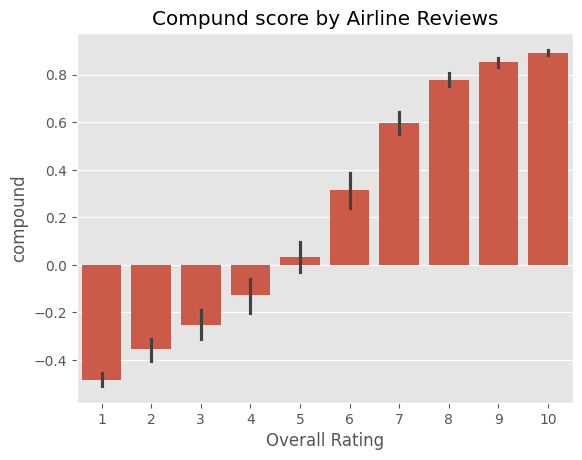

In [27]:
#Plot vaders results
ax = sns.barplot(data = vaders, x = 'Overall Rating', y = 'compound')
ax.set_title('Compund score by Airline Reviews')
plt.show()

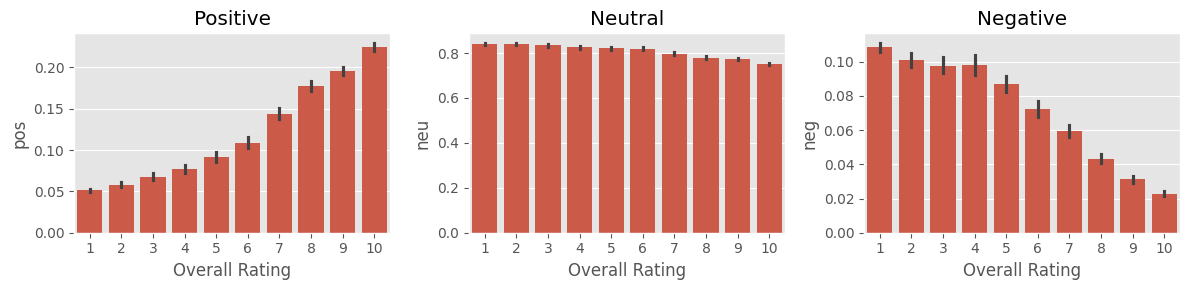

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Overall Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Overall Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Overall Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [29]:
# defining train and test sets
X = df['Reviews']
y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
                                    0 if x >= 4.0 and x <= 6.1 else
                                    -1 )
y.value_counts()

# Preprocess text data
X_preprocessed = sentence_level_preprocessing(X)

# Preprocessing and feature extraction
vader = SentimentIntensityAnalyzer()
X_text = X_preprocessed.copy()  
X_vader_features = [vader.polarity_scores(text) for text in X_text]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vader_features, y, test_size=0.2, random_state=42)

# Training
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
X_preprocessed[0]

'flight amaz crew onboard flight welcom gave good atmospher crew serv aisl goe initi g kind help gave mom bday cake late celebr even though hr min flight seat well sanit legroom spaciou ife onboard mani varieti show music etc bathroom alway kept clean crew time food delici overal flight'

In [ ]:
print(X_vader_features)

[{'neg': 0.0, 'neu': 0.761, 'pos': 0.239, 'compound': 0.9153}, {'neg': 0.326, 'neu': 0.548, 'pos': 0.126, 'compound': -0.8074}, {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.4588}, {'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.9545}, {'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.9118}, {'neg': 0.13, 'neu': 0.788, 'pos': 0.082, 'compound': -0.6369}, {'neg': 0.0, 'neu': 0.941, 'pos': 0.059, 'compound': 0.4215}, {'neg': 0.059, 'neu': 0.702, 'pos': 0.239, 'compound': 0.7506}, {'neg': 0.085, 'neu': 0.806, 'pos': 0.109, 'compound': 0.765}, {'neg': 0.022, 'neu': 0.675, 'pos': 0.303, 'compound': 0.9506}, {'neg': 0.124, 'neu': 0.734, 'pos': 0.141, 'compound': 0.0772}, {'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'compound': 0.743}, {'neg': 0.088, 'neu': 0.658, 'pos': 0.255, 'compound': 0.7269}, {'neg': 0.022, 'neu': 0.855, 'pos': 0.123, 'compound': 0.8126}, {'neg': 0.172, 'neu': 0.486, 'pos': 0.342, 'compound': 0.8684}, {'neg': 0.1, 'neu': 0.747, 'pos': 0.152, 'compound': 0

### 2.2 Random Forest Classifier with 10 CV

In [32]:
# defining train and test sets
X = df['Reviews']
y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 10.1 else
                                    0 if x >= 4.0 and x <= 6.1 else
                                    -1 )
y.value_counts()

# Preprocess text data
X_preprocessed = sentence_level_preprocessing(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Vectorize preprocessed text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features= 5000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

#perform 10 fold cv 
val_scores = cross_val_score(rf_model,X_train_tfidf,y_train, cv = 10,scoring= 'accuracy')

# Print the mean accuracy and standard deviation
print("Mean val Accuracy:", val_scores.mean())
print("Val Standard Deviation:", val_scores.std())

# Predict ratings
y_pred = rf_model.predict(X_test_tfidf)

#predictions accuracy
acc = accuracy_score(y_test.values.reshape(-1, 1), y_pred)
print('prdiction accuracy:', acc)


Mean val Accuracy: 0.783641975308642
Val Standard Deviation: 0.014423853636478915
prdiction accuracy: 0.7851851851851852


### 3.0 Logistic Regression 

In [183]:
# defining train and test sets
X = df['Reviews']
y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
                                    0 if x >= 4.0 and x <= 6.1 else
                                    -1 )
print(y.value_counts())

# Preprocess text data
X_preprocessed = sentence_level_preprocessing(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Vectorize preprocessed text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty = 'l2', C = 1.8976381856548117, max_iter = 353, multi_class='ovr', solver='lbfgs', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

#perform 10 fold cv 
val_scores = cross_val_score(lr_model,X_train_tfidf,y_train, cv = 3,scoring= 'accuracy')

# Print the mean accuracy and standard deviation
print("Mean val Accuracy:", val_scores.mean())
print("Val Standard Deviation:", val_scores.std())

# Predict ratings
y_pred = lr_model.predict(X_test_tfidf)

#predictions accuracy
acc = accuracy_score(y_test.values.reshape(-1, 1), y_pred)
print('prdiction accuracy:', acc)

Overall Rating
 1    3915
-1    3022
 0    1163
Name: count, dtype: int64
Mean val Accuracy: 0.8018518518518518
Val Standard Deviation: 0.011899739289294425
prdiction accuracy: 0.8037037037037037


#### 3.1 Hyperparameter Optimisation Logistic Regression 

In [181]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# # defining train and test sets
# X = df['Reviews']
# y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
#                                     0 if x >= 4.0 and x <= 6.1 else
#                                     -1 )
# print(y.value_counts())

# # Preprocess text data
# X_preprocessed = sentence_level_preprocessing(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     penalty = trial.suggest_categorical('penalty', ['l2'])  # Regularization type
#     C = trial.suggest_loguniform('C', 0.001, 10)  # Regularization strength
#     max_iter = trial.suggest_int('max_iter', 100, 1000)  # Maximum number of iterations
#     class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    
#     # Train Logistic Regression model with hyperparameters
#     lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', penalty=penalty, C=C, max_iter=max_iter,
#                                   class_weight=class_weight, random_state=42)
#     val_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
#     # Return mean validation accuracy as the objective value to maximize
#     return val_scores.mean()

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print(best_params)

# # Train Logistic Regression model with best hyperparameters
# lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', **best_params, random_state=42)
# lr_model.fit(X_train_tfidf, y_train)

# # Predict ratings
# y_pred = lr_model.predict(X_test_tfidf)

# # Calculate accuracy
# acc = accuracy_score(y_test, y_pred)
# print('Prediction accuracy:', acc)

# #best acc 80.37

Overall Rating
 1    3915
-1    3022
 0    1163
Name: count, dtype: int64


[I 2024-04-28 17:58:35,147] A new study created in memory with name: no-name-05f891c6-9a0a-4730-8e3c-1538d9cbf765
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_5316/1774006226.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.001, 10)  # Regularization strength
[I 2024-04-28 17:58:36,014] Trial 0 finished with value: 0.7725308641975308 and parameters: {'penalty': 'l2', 'C': 5.3225364310590635, 'max_iter': 103, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7725308641975308.
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_5316/1774006226.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = tri

Prediction accuracy: 0.8037037037037037
